In [ ]:
from collections import OrderedDict

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

## CompositeLayer is an nn.Module with the following layers (in order):

### 1. BatchNorm2d with default parameters
### 2. ReLU
### 3. Conv2d with kernel_size=1, stride=1, bias=False, all others default values
### 4. BatchNorm2d with default parameters
### 5. ReLU
### 6. Conv2d with kernel_size=3, stride=1, padding=1, bias=False, all others default values

#### These layers are connected in a sequential order (i.e., 1-2-3-4-5-6)

## Fill the blanks marked by "##ToAdd:" in the following cell

In [ ]:
class CompositeLayer(nn.Module):
    def __init__(self, num_input_features, num_hidden_features, num_output_features):
        """
        Arguments:
            num_input_features: int, num_features for the first BatchNorm2d
            num_hidden_features: int, out_channels for the first Conv2d
            num_output_features: int, out_channels for the second Conv2d
        """
        super(CompositeLayer, self).__init__()
        ##ToAdd: add the layers specified above
        self.norm1 = nn.BatchNorm2d(num_features=num_input_features)##ToAdd: layer BatchNorm2d with default parameters
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels=num_input_features, out_channels=num_hidden_features, kernel_size=1, padding=1, stride=1, bias=False)
        self.norm2 = nn.BatchNorm2d(num_features=num_hidden_features)##ToAdd: layer BatchNorm2d with default parameters
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=num_hidden_features, out_channels=num_output_features, kernel_size=3, padding=1, stride=1,bias=False)
        ##EndAdd

    def forward(self, inputs):
        """
        Args:
            inputs: a torch.Tensor or a list of torch.Tensor
        """
        if isinstance(inputs, list):
            inputs = torch.cat(inputs, 1)
        ##ToAdd: forward pass from inputs to outputs
            out = self.conv1(inputs)
            out = self.relu(self.norm1(out))
            out = self.conv2(out)
            out = self.relu(self.norm2(out))
            out = out.squeeze()
        ##EndToAdd
        return outputs

## Block consists of a number (argument `num_layers`) of CompositeLayer defined above:
### To illustrate how it works, let's set `num_layers=4` for a Block model.
### Then it will have 4 CompositeLayer. Let's name them as `layer1`, `layer2`, `layer3`, and `layer4`.
### The input of `layer1` is provided as `init_features` in the `forward` function defined below.
### `init_features` and the output of `layer1` will be concatenated together at the channel dimension as the input of `layer2`
## `init_features`, the output of `layer1` and the output of `layer2` concatenated together at the channel dimension (dim=1) will be the input of `layer3`.
## `init_features`, the outputs of `layer1`, `layer2`, and `layer3` concatenated together at the channel dimension (dim=1) will be the input of `layer4`.
## So the input of `layer{i}` is the concatenated outputs of all its previous layers from `layer1` until `layer{i-1}` as well as `init_features`
## The model `forward` function returns the `init_features` and ALL OUTPUTS of all layers concatenated together at the channel dimension (dim=1)


## Fill the blanks marked by "##ToAdd:" in the following cell

In [ ]:
class Block(nn.ModuleDict):
    def __init__(self, num_layers, num_input_features, num_hidden_features, num_output_features):
        """
        Arguments:
            num_layers: int, how many CompositeLayer are included
            num_input_features: int, num_input_features for the FIRST CompositeLayer (YOU NEED TO CALCULATE the num_input_features for all other CompositeLayer)
            num_hidden_features: int, num_hidden_features for every CompositeLayer
            num_output_features: int, num_output_features for every CompositeLayer
        """
        super(Block, self).__init__()
        for i in range(num_layers):
            ##ToAdd: Add a number of CompositeLayer. Hint: define a CompositeLayer with proper arguments, and use add_module function to add it to self
            CompositeLayer=Block(i,num_input_features,num_hidden_features,num_output_features)
            self.add_module('layer%d' % (i + 1), CompositeLayer)

            ##EndAdd

    def forward(self, init_features):
        """
        Arguments:
            init_features: torch.Tensor, the input of the first CompositeLayer
        """
        features = [init_features]
        ##ToAdd: forward pass. Hint: Append the output of each layer to features one at a time until the last layer
        for l in range('layer%d' % (i + 1)):
            out = self.layer(l)(features)
            features.append(out)

        ##EndAdd
        return torch.cat(features, 1)

## ConvPool is nn.Sequential with the following layers (in order):

### 1. BatchNorm2d with default parameters
### 2. ReLU
### 3. Conv2d with kernel_size=1, stride=1, bias=False, all others default values
### 4. AvgPool2d with kernel_size=2, stride=2, all others default values

#### For a subclass of nn.Sequential, you only need to define `__init__` (the `forward` function is already defined in nn.Sequential)

## Fill the blanks marked by "##ToAdd:" in the following cell

In [ ]:
class ConvPool(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        """
        Arguments:
            num_input_features: int, num_features for the BatchNorm2d layer
            num_output_features: int, out_channels for the Conv2d layer
        """
        super(ConvPool, self).__init__()
        ##ToAdd: add the layers specified above; hint: use add_module function in nn.Sequential class
        self.add_module('norm1',nn.BatchNorm2d(num_features=num_input_features))##ToAdd: layer BatchNorm2d with default parameters
        self.add_module('relu1',nn.ReLU(inplace=True))
        self.add_module('conv1' ,nn.Conv2d(in_channels=num_input_features, out_channels=num_output_features, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2,stride=2))

        ##EndAdd

## BlockNet is more complex. It consists multiple Block layers (Note each Block layer consists of multiple CompositeLayer), specified by `block_config`.
## The model architecture is as follows:
### First convolutional layer (already defined for you) to process the input
### A number of Block layers and ConvPool layers you need to add
### Final layers such as AvgPool2d and Linear to predict the class labels (already defined for you)


## Fill the blanks marked by "##ToAdd:" in the following cell

In [ ]:
class BlockNet(nn.Module):
    def __init__(self, block_config=(6, 12, 24, 16), num_init_features=64,
                 num_hidden_features=128, num_output_features=32, num_classes=10):
        """
        Arguments:
            block_config: list of ints, how many layers in Block layer
            num_init_features: int, num_input_features for the FIRST Block layer. (You need to calculate the num_input_features for all other Block layers)
            num_hidden_features: int, num_hidden_features for ALL Block layers
            num_output_features: int, num_output_features for ALL Block layers
            num_classes: int, number of classes, out_features for the last Linear layer (already defined for you)
        """
        super(BlockNet, self).__init__()

        # First convolution already defined for you
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))]))

        # A number of Block and ConvPool layers
        num_features = num_init_features #num_features is used as the num_input_features for each Block layer
        for i, num_layers in enumerate(block_config):
            ##ToAdd: Define a Block layer with num_input_features=num_features
            block = Block(num_layers=num_layers, num_input_features=num_features, num_hidden_features=num_hidden_features,
                          num_output_features=num_output_features)
            ##EndAdd
            self.features.add_module(f'block{i+1}', block)

            ##ToAdd: calculate num_features as the output of the Block layer
            num_features = num_features+ num_output_features*num_layers
            ## EndAdd

            if i != len(block_config) - 1:
                # All Block layers Except the last one is followed by a ConvPool layer
                # Important: ConvPool layer will reduce the number of features by half
                ##ToAdd: add a ConvPool layer with num_input_features=num_features, num_output_features=num_features//2
                convpool = ConvPool( num_input_features=num_features, num_output_features=num_features//2 )
                ##EndAdd
                self.features.add_module(f'convpool{i+1}', convpool)
                # Here we update the num_features, which will be used for the next Block layer in this for loop
                num_features = num_features // 2
        # Final batch norm
        self.features.add_module(f'norm{len(block_config)+1}', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

## Well done!
## You don't need to change the following cells. They are here for you to learn how to train a computer vision model in practice
## You can also test your implemented BlockNet model using it
## If you can build a good BlockNet model (change `block_config`, `num_init_features`, `num_hidden_features`, `num_output_features`) and train it well (change optimizer, learning rate, num_epochs, etc.), you will get some extra credit in case you haven't gotten a perfect score. You are highly recommended to do so!

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validationset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, pin_memory=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=1024,
                                          shuffle=False, pin_memory=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, pin_memory=True, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
writer = SummaryWriter('runs/cifar10')
model = BlockNet((2, 3), num_init_features=16, num_hidden_features=32, num_output_features=16, num_classes=10)
writer.add_graph(model, torch.randn(1, 3, 32, 32))
writer.close()

TypeError: ignored

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model).to(device)
else:
    model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def get_acc(model, loader):
    with torch.no_grad():
        correct = 0
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (labels == outputs.argmax(dim=1).squeeze()).sum()
        acc = float(correct) / len(loader.dataset)
    return acc

In [ ]:
num_epochs = 8
eval_every = 100
train_acc_his = []
val_acc_his = []
test_acc_his = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % eval_every == 0:
            train_acc = get_acc(model, trainloader)
            val_acc = get_acc(model, validationloader)
            test_acc = get_acc(model, testloader)
            train_acc_his.append(train_acc)
            val_acc_his.append(val_acc)
            test_acc_his.append(test_acc)
            writer.add_scalar('train_acc', train_acc, len(train_acc_his))
            writer.add_scalar('val_acc', val_acc, len(val_acc_his))
            writer.add_scalar('test_acc', test_acc, len(test_acc_his))
            print('[epoch %d, iter %d] train_acc: %.3f  val_acc: %.3f  test_acc: %.3f' %
                  (epoch+1, i+1, train_acc, val_acc, test_acc))

NameError: ignored

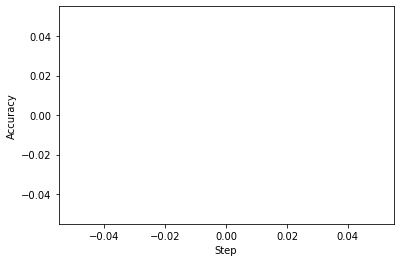

In [ ]:
plt.plot(train_acc_his, 'ro-', label='train')
plt.plot(val_acc_his, 'bv-', label='validation')
plt.plot(test_acc_his, 'g+-', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.show()